In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import wisps.simulations.effective_numbers as eff
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm 
import pandas as pd
import matplotlib as mpl
%matplotlib inline

In [2]:
from wisps import drop_nan

In [3]:
baraffe_data=eff.simulation_outputs()["baraffe2003"]
saumon_data=eff.simulation_outputs()["saumon2008"]


In [4]:
import seaborn as sns

In [5]:
cmap_teff=sns.diverging_palette(100, 300, s=80, l=55, n=19, as_cmap=True)

In [6]:
pnts=wisps.OBSERVED_POINTINGS

In [7]:
volumes=[]
dlimits=[]
for pnt in pnts:
    vs=[]
    dls=[]
    for g in wispsim.SPGRID:
        vsx=[]
        for h in wispsim.HS:
            vsx.append((pnt.volumes[h])[g])
        dls.append(pnt.dist_limits[g])
        vs.append(vsx)
    volumes.append(vs)
    dlimits.append(dls)
volumes=np.array(volumes)
dlimits=np.array(dlimits)

In [8]:
galc=SkyCoord([x.coord.galactic for x in pnts])

In [9]:
vls250=volumes[:,0, :,]

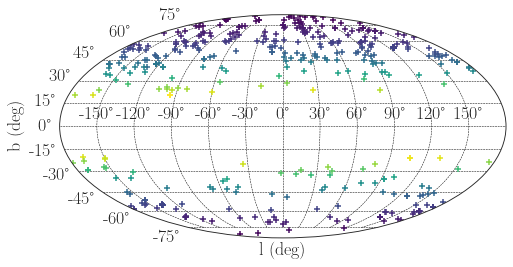

In [10]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection="mollweide")
c=ax.scatter(galc.l.wrap_at(180*u.degree).radian,galc.b.wrap_at(90*u.degree).radian, 
           c=np.log10(vls250[:,0]), marker='+', cmap='viridis')
ax.set_xlabel('l (deg)', fontsize=18)
ax.set_ylabel('b (deg)', fontsize=18)
plt.grid()

In [11]:
from matplotlib.colors import Normalize
import seaborn as sns
cnorm=Normalize(wispsim.HS[0]/100, wispsim.HS[-1]/100)

In [12]:
from scipy import integrate

In [13]:
volume_fx=np.vectorize(wispsim.custom_volume)

In [18]:
import seaborn as sns
cmap= sns.cubehelix_palette(light=1, as_cmap=True)

7it [00:01,  6.30it/s]


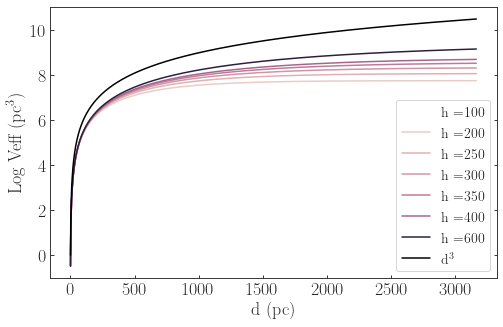

In [20]:
ds=np.logspace(0, 3.5, 1000)
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in tqdm(enumerate(wispsim.HS)):
    plt.plot(ds, np.log10(volume_fx(0.,np.pi/4, 0, ds,h)), color=cmap(cnorm(h/100)), label=r'h ={}'.format(h))
plt.plot(ds, np.log10(ds**3), c='k', label=r'd$^3$')
plt.ylabel(r'Log Veff (pc$^3$)', fontsize=18)
plt.xlabel('d (pc)', fontsize=18)
plt.legend(fontsize=14)

In [21]:
vsunif=np.nansum((dlimits[:, :,0])**3-(dlimits[:, :,1])**3, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

In [22]:
VOLUMES=np.nansum(volumes.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)

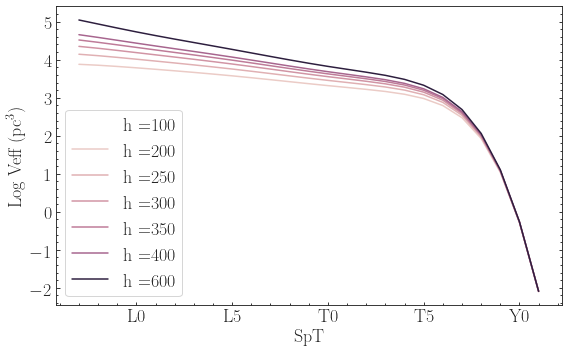

In [23]:
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in enumerate(wispsim.HS):
    plt.plot(wispsim.SPGRID, np.log10(VOLUMES[idx]), color=cmap(cnorm(h/100)), label=r'h ={}'.format(h))

#plt.plot(wispsim.SPGRID, np.log10(vsunif), label=r'd$^3$' )
plt.ylabel(r'Log Veff (pc$^3$)', fontsize=18)
plt.xlabel('SpT', fontsize=18)
plt.legend(fontsize=18)

plt.minorticks_on()

plt.tight_layout()
ax.set_xticks([20, 25, 30, 35, 40])
ax.set_xticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_volumes.pdf', bbox_inches='tight')

In [24]:
bays_distances=eff.BAYESIAN_DISTANCES_VOLUMES

In [25]:
bays_distances.keys()

dict_keys(['distances', 'rs', 'zs'])

In [26]:
def get_kde(r, z):
    kde=wisps.kernel_density([r, z])
    dens=kde.pdf([r, z])

In [ ]:
fig, (ax, ax1)=plt.subplots( figsize=(8, 10), ncols=2, nrows=2)

h=ax[0].hist(bays_distances['distances'][250].flatten(), color='#FF4136',
          bins='auto', histtype='step', label="h = 250 pc")

h=ax[0].hist(bays_distances['distances'][600].flatten(),  color='#0074D9', bins='auto', 
          histtype='step', label="h = 600 pc")


h=ax[1].hist(bays_distances['zs'][250].flatten(), color='#FF4136',
          bins='auto', histtype='step', label="h = 250 pc")

h=ax[1].hist(bays_distances['zs'][600].flatten(),  color='#0074D9', bins='auto', 
          histtype='step', label="h = 600 pc")

ax1[0].scatter(bays_distances['rs'][250].flatten(), bays_distances['zs'][250].flatten(), alpha=0.01, s=1.)

ax1[1].scatter(bays_distances['rs'][600].flatten(), bays_distances['zs'][600].flatten(),alpha=0.01, s=1.)





ax[0].legend(fontsize=15, loc='lower left')
ax[0].set_xlabel('Distance (pc)', fontsize=18)
ax[0].set_ylabel('N', fontsize=18)

ax[1].set_xlabel('Z (pc)', fontsize=18)
ax[1].set_ylabel('N', fontsize=18)
ax[1].set_yscale('log')

ax1[0].legend(fontsize=15, loc='lower left')
ax1[0].set_xlabel('R (pc)', fontsize=18)
ax1[0].set_ylabel('Z (pc)', fontsize=18)

ax1[1].legend(fontsize=15, loc='lower left')
ax1[1].set_xlabel('R (pc)', fontsize=18)
ax1[1].set_ylabel('Z (pc)', fontsize=18)



for a in np.concatenate([ax, ax1]):
    a.minorticks_on()
    
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_distances.jpeg', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [28]:
maglimits=pd.DataFrame([x.mag_limits for x in pnts])
exposure_times=[np.nanmean(x.exposure_time) for x in pnts]

In [29]:
wispsim.MAG_LIMITS

{'wisps': {'F110': (poly1d([ 1.55004089, 16.70448803]), 0.5745929550578502),
  'F140': (poly1d([ 1.241343  , 16.89157194]), 0.9349842615039278),
  'F160': (poly1d([ 0.18777862, 20.71761789]), 1.7432078125291122)},
 'hst3d': {'F110': (None, nan),
  'F140': (poly1d([ 0.35853188, 21.55963996]), 0.18321541773204744),
  'F160': (poly1d([ 0.38589948, 21.3533637 ]), 0.1832225995011817)}}

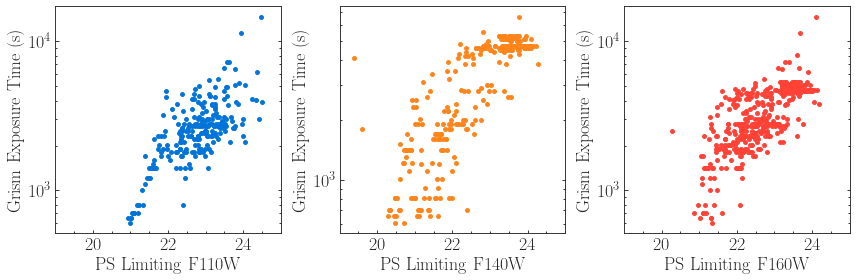

In [30]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(maglimits.F110, exposure_times, c='#0074D9', s=15.)
ax[1].scatter(maglimits.F140, exposure_times, c='#FF851B', s=15.)
ax[2].scatter(maglimits.F160, exposure_times, c='#FF4136', s=15.)
for a,k in zip(ax, maglimits.columns):
    a.set_xlim([19, 25])
    a.set_yscale('log')
    a.minorticks_on()
    a.set_xlabel('PS Limiting '+ k+'W', fontsize=18)
    a.set_ylabel('Grism Exposure Time (s)', fontsize=18)
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit.pdf', bbox_inches='tight')

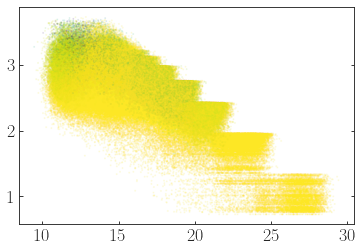

In [31]:
plt.scatter(np.array(baraffe_data['f110']).flatten(),
            np.log10(np.array(baraffe_data['dists']).flatten()), c= np.array(baraffe_data['sl_prob']).flatten(), 
            s=1., alpha=0.1, cmap='viridis')

In [32]:
saumon_data.keys()

dict_keys(['f110', 'f140', 'hs', 'f160', 'appf140s', 'appf110s', 'appf160s', 'dists', 'snrjs', 'spgrid', 'spts', 'sl_prob', 'pointing', 'mass', 'age'])

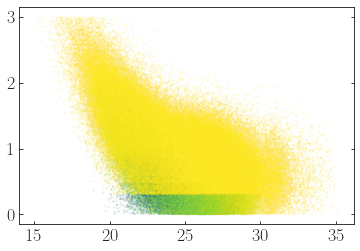

In [33]:
plt.scatter(np.array(saumon_data['appf160s']).flatten(), 
            np.log10(np.array(saumon_data['snrjs']).flatten()),
            c= np.array(saumon_data['sl_prob']).flatten(), 
            s=1., alpha=0.1, cmap='viridis')

#check if doing mean vs fits make a difference 